---
title: "11.X Case Study: Eigenfaces"
subject: Principal Component Analysis Application
subtitle: Eigenfaces
short_title: "11.X Eigenfaces"
authors:
  - name: Nikolai Matni
    affiliations:
      - Dept. of Electrical and Systems Engineering
      - University of Pennsylvania
    email: nmatni@seas.upenn.edu
license: CC-BY-4.0
keywords: nodes, edges, Kirchoff`s law
math:
  '\vv': '\mathbf{#1}'
  '\bm': '\begin{bmatrix}'
  '\em': '\end{bmatrix}'
  '\R': '\mathbb{R}'
---

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/nikolaimatni/ese-2030/HEAD?labpath=/10_Ch_11_Principal_Component_Analysis/123-eigenfaces.ipynb)


## Learning Objectives

By the end of this page, you should know:
- how to decompose a dataset of images into the sum of principle components
- how to compress a new image using the principle components of the dataset

## Eigenface definition
Eigenface is a concept introduced by Sirovich and Kirby in 1987. It involves using principal component analysis (PCA) based on singular value decomposition (SVD) to reduce the dimensionality of face images. This method creates a set of r basic features, known as eigenpictures or eigenfaces, which can be linearly combined to represent the original n face images, with r being less than n.

This concept is essential for facial recognition. Subsequently, various preprocessing techniques, such as gamma correction for illumination adjustments, were developed to enhance its accuracy.

## Exploring the dataset
In this case study, we will consider a dataset from the LFW (Labeled Faces in the Wild dataset). The dataset consists of over 10000 images of faces, however we will only use 1000 in this case study. Each image is 62 pixels x 47 pixels and is represented without color (in black and white). Below, we load the dataset, and show one face from the dataset. 

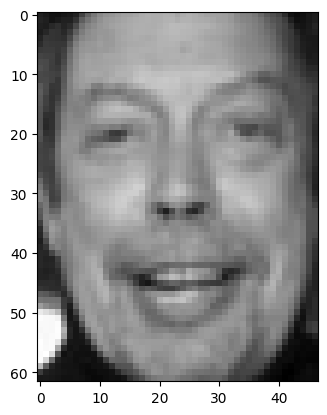

In [2]:
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
faces = fetch_lfw_people()

plt.imshow(faces.images[0], cmap='grey')

Let's verify that the shape of the image is indeed 62x47:

In [3]:
print(faces.images[0].shape)

(62, 47)


Perfect, the image size is as expected. Below we will trim our dataset to use $1000$ images to form our eigenfaces, and $2$ images to evaluate the results. There are duplicate faces, so we will ensure that we are selecting $1002$ unique faces. 

In [4]:
unique_face_images = []
held_out_faces = []
seen_names = []

i = 0
while len(unique_face_images) < 1000:
    if not faces.target_names[faces.target[i]] in seen_names:
        unique_face_images.append(faces.images[i])
        seen_names.append(faces.target_names[faces.target[i]])
    i += 1

while len(held_out_faces) < 2:
    if not faces.target_names[faces.target[i]] in seen_names:
        held_out_faces.append(faces.images[i])
        seen_names.append(faces.target_names[faces.target[i]])
    i += 1

We now visualize several of the the faces that we will use to construct the eigenfaces below.

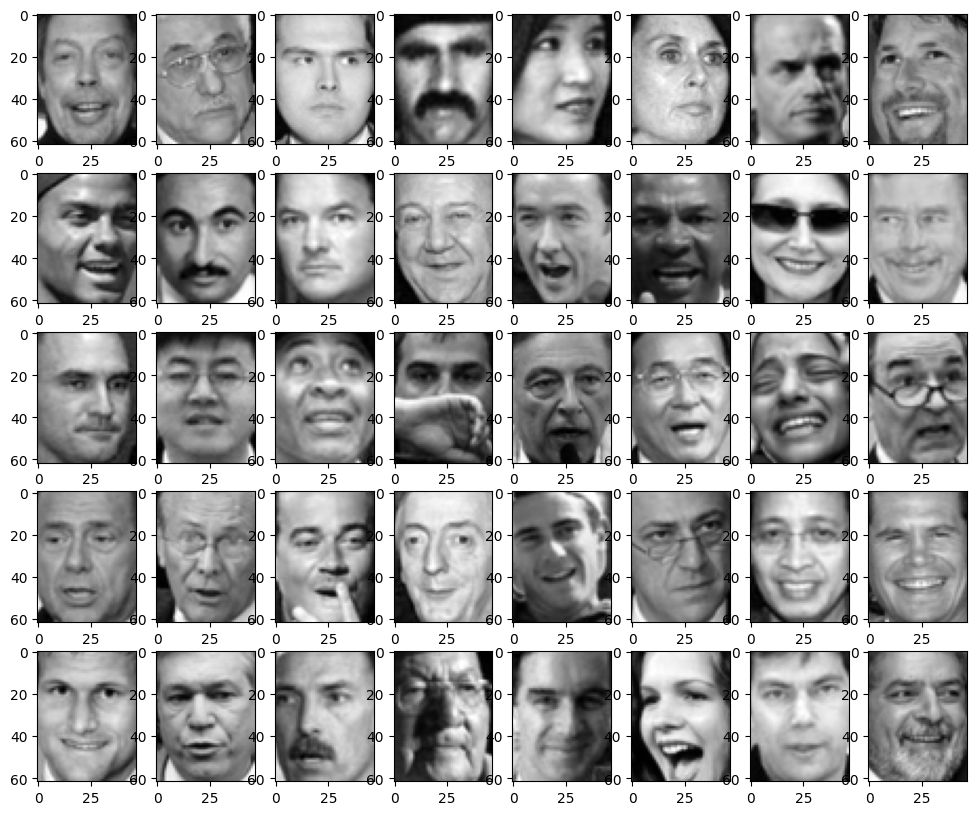

In [5]:
fig, ax = plt.subplots(5, 8, figsize=(12, 10))
for i, axi in enumerate(ax.flat):
    axi.imshow(unique_face_images[i], cmap='grey')

The two heldout faces that will be used to evaluate the resulting eigenfaces are as follows. 

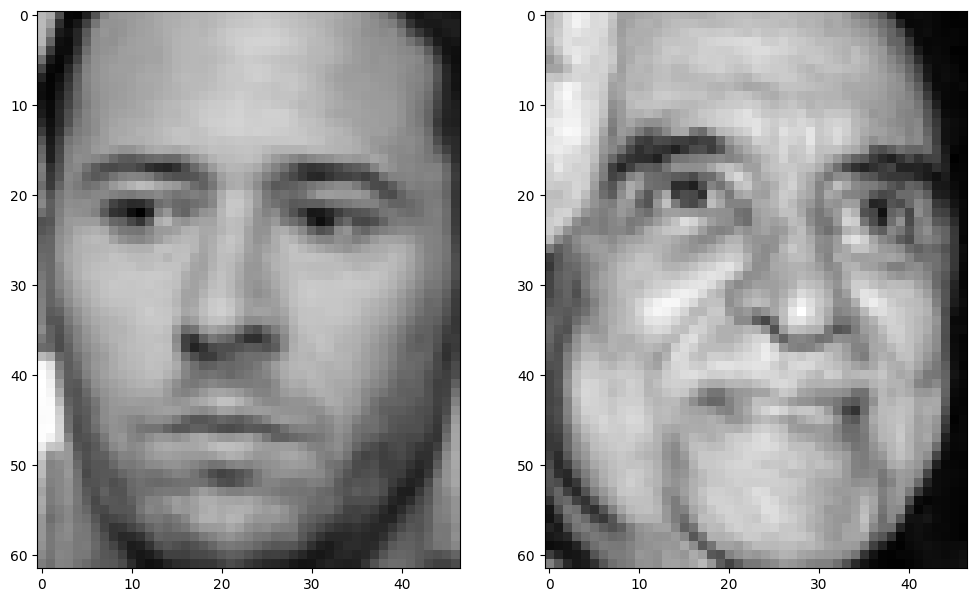

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 10))
for i, axi in enumerate(ax.flat):
    axi.imshow(held_out_faces[i], cmap='grey')

## Principle Component Analysis on Face Images
To construct our eigenfaces, we will convert each of our $62\times47$ images into vectors of length $62*47 = 2914$. Each vector will then be stacked into a matrix, which we will call $X$. 

In [7]:
import numpy as np
X = np.stack([face.flatten() for face in unique_face_images], axis=1)

print(X.shape)

(2914, 1000)


We have therefore stacked our $1000$ vectorized images into a matrix of shape $2914 \times 1000$. We will now perform principle component analysis on the vectorized face images. This can be performed by first subtracting the mean of all of the images, then taking a singular value decomposition of the stacked face data. 

In [8]:
mean = np.mean(X, axis=1, keepdims=True)
U, Sigma, Vt = np.linalg.svd(X - mean)

Note that we have called the third output of the svd function $Vt$ rather than $V$. This is because the svd function already outputs the transposed $V$ matrix. Let's check that the singular value decomposition conforms to the sizes that we expect. 

In [9]:
print('U shape: ', U.shape)
print('Sigma shape: ', Sigma.shape)
print('Vt shape: ', Vt.shape)

U shape:  (2914, 2914)
Sigma shape:  (1000,)
Vt shape:  (1000, 1000)


It appears that Sigma is a one dimensional list of numbers, and therefore represents only the singular values. It also appears that $U$ is a square matrix, even though we only expect it to be of shape $2914 \times 1000$. The reason for this is that numpy defaults to use "full\_matrices" in the singular value decomposition. However, this is an option that we can change. 

In [10]:
U, Sigma, Vt = np.linalg.svd(X - mean, full_matrices=False)

print('U shape: ', U.shape)
print('Sigma shape: ', Sigma.shape)
print('Vt shape: ', Vt.shape)

U shape:  (2914, 1000)
Sigma shape:  (1000,)
Vt shape:  (1000, 1000)


The result now conforms with our expectations. Let's verify that the decomposition indeed represents the original matrix by checking the largest deviation between the reconstructed matrix and the original.

In [11]:
print(np.max(X - mean - U@np.diag(Sigma)@Vt))

1.2516975e-06


Up to a small numerical tolerance, the svd is correct! Let's look at the singular values on a log plot, and consider what they mean.

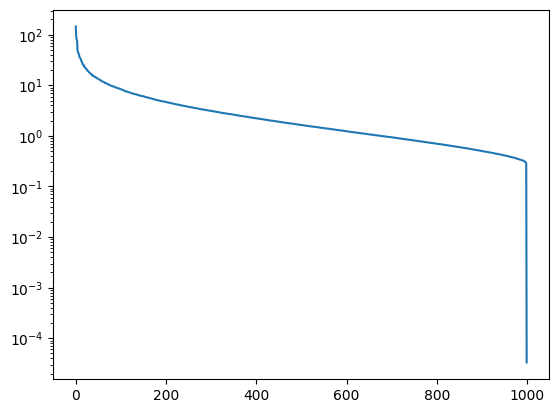

In [12]:
plt.plot(Sigma)
plt.yscale('log')

The first few singular valuse are orders of magnitude larger than the subsequent ones. After that, the size slowly decays all the way out to the total number of faces used, $1000$. Using the theory of PCA taught earlier in this chapter, we find that much of the variety in the faces constituting the matrix $X$ is described by a relatively small number of components. This is the essential idea of eigenfaces. 

We will consider the most significant components of the space of faces, determined by the columns of $U$ corresponding to the largest singular values. As the singular values are sorted in nonincreasing order, the $r$ most signficant singular values are the first $r$ singular values, and therefore, the $r$ most significant components are the first $r$ columns of $U$. If we reshape these columns back into images, we have recovered our *eigenfaces*. Let's obtain $40$ of these eigenfaces, and examine them below. 

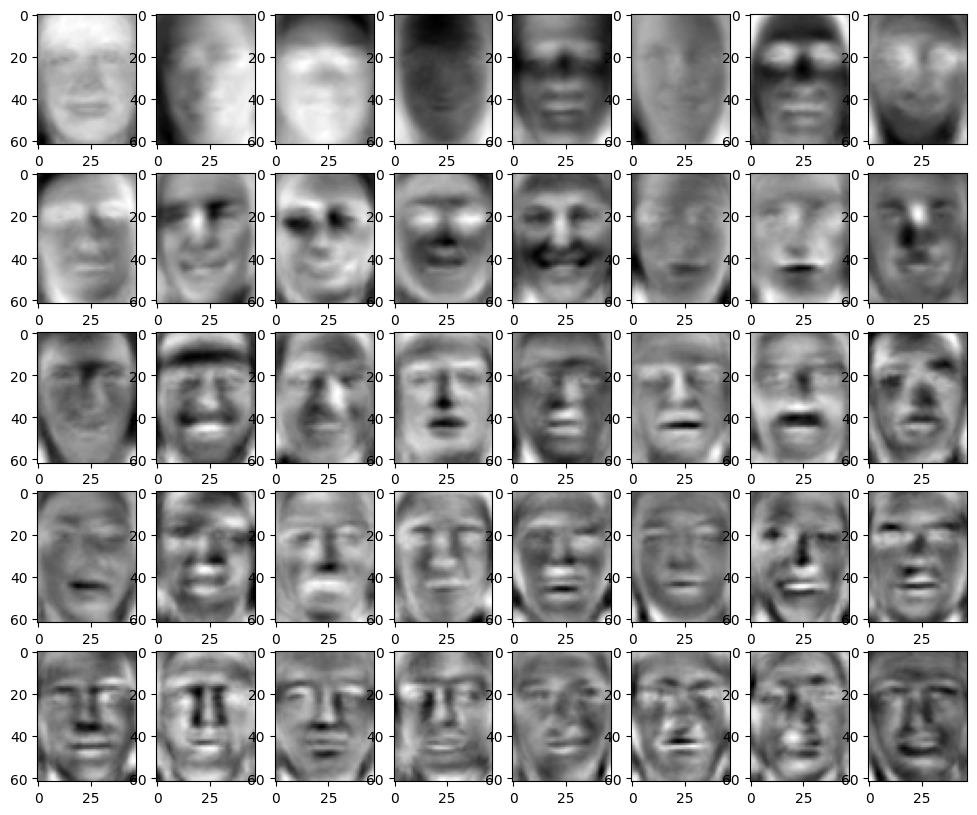

In [13]:
n_components = 40
U_significant = U[:,:n_components]

eigenfaces = [U_significant[:,i].reshape((62,47)) for i in range(n_components)]

fig, ax = plt.subplots(5, 8, figsize=(12, 10))
for i, axi in enumerate(ax.flat):
    axi.imshow(eigenfaces[i], cmap='grey')

The eigenfaces are sorted by significance with significance decreasing as we go down columns and to the right across rows. We see that the most significant components are simply blurred silhouttes of faces. However, then some very interesting phenomena start to arise where components consist clearly of particular features of the face. We start with the eyes and eyebrows. Then we move to finer features like the lips and nose. 

As interesting as the above figures are on their own, we are still left with the question of how we can actually use these eigenfaces for something practical. Below, we will examine how to use these faces for image compression. However, the approach can also be used to perform facial recognition if you have multiple photos of a single individual. 

## Compression
To study compression, we will use the two held out faces that were not included to construct these eigenfaces. We will look at how well those faces can be represented by these eigenfaces. If we can represent these faces, which consist of 62x47=1219 pixels, in terms of relatively few, (perhaps a couple hundred) eigenfaces, then we have meaningfully compressed our image. This enables more efficient storage and communication of these images. Now that we already have our eigenfaces, compression is easy. We simply vectorize our new image, subtract off the mean $\mu$, and multiply it by the significant features:
$$
\mathbf I_{\mathsf{compressed}} = U_{\mathsf{significant}}^\top \mathbf (I_{\mathsf{original}} - \mu).  
$$

To reconstruct the original image, we simply multiply the compressed representation by the significant features, then add the mean $\mu$. 
$$
\mathbf I_{\mathsf{reconstruction}} = U_{\mathsf{significant}} \mathbf I_{\mathsf{compressed}} + \mu
$$

Below, we'll obtain the compressions for the two heldout images. 

In [14]:
compressed_faces = []

for i, face in enumerate(held_out_faces):
    compressed_faces.append(U_significant.T@(face.flatten() - mean.squeeze()))
    print(f'heldout face {i}: ', compressed_faces[-1])

heldout face 0:  [ 3.3402014  -1.3358479   0.42355394 -0.7542747   1.2138596  -1.3151665
 -2.093287    2.799038    0.24347794  1.08534     0.13356411 -1.4813893
 -0.9036138  -1.9992326   0.78760695  0.2505779   0.04489435 -0.33163184
  0.85100716  0.23772538 -0.56633806  0.10866132 -1.1363678  -0.16886455
 -0.4312972  -0.1055222   0.125719    0.39842254 -0.9618645  -0.1858159
  0.55226994  0.4459834   0.7888346  -0.03883459 -0.49556684 -0.4177999
  0.02057935  0.69985324 -0.5973932  -0.10933232]
heldout face 1:  [ 3.6934466e+00 -2.7483964e+00  2.9404578e+00 -1.3590658e+00
 -4.7455686e-01 -8.2089096e-01  1.4987757e+00 -1.7925804e+00
 -2.3967748e+00 -1.2036872e+00  6.7564392e-01  6.1025065e-01
 -2.8707656e-01 -1.1593044e+00 -1.8275348e-02 -1.1537762e-01
  2.4545018e-02  2.2632088e-01 -2.0420890e+00  3.4338909e-01
  6.0545456e-01 -4.6391863e-01 -3.7148610e-02 -1.3836183e-01
 -1.5389979e-01  3.3462441e-01 -7.5793755e-01  3.9263773e-01
 -7.5432873e-01  4.9102443e-01 -3.1850177e-01  1.971798

The compressed faces above are rather uninterpretable, as they are simply lists of numbers with 40 components. Let's try reconstructing the original faces from the compression, and comparing them to the origials. 

In [15]:
print(mean.squeeze())

[0.27075818 0.27840003 0.29756996 ... 0.40544972 0.39138302 0.37946668]


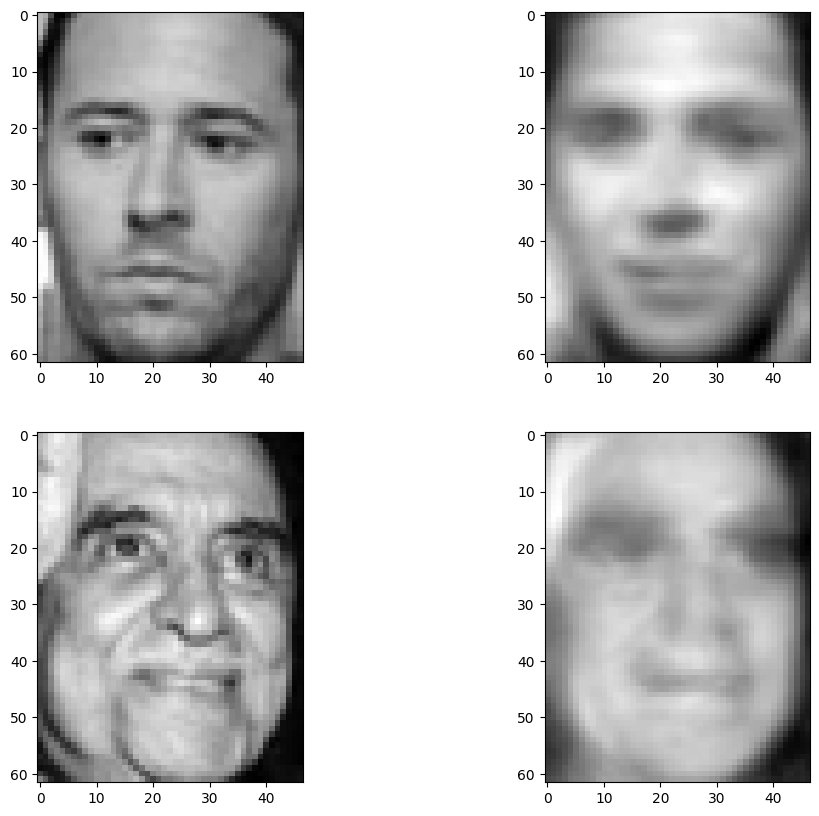

In [17]:
reconstructed_faces = []
for compressed_face in compressed_faces:
    reconstructed_faces.append((U_significant@compressed_face + mean.squeeze()).reshape(62, 47))
    
fig, ax = plt.subplots(len(compressed_faces), 2, figsize=(12, 10))

for i, (reconstructed_face, true_face) in enumerate(zip(reconstructed_faces, held_out_faces)):
    ax[i,0].imshow(true_face, cmap='grey')
    ax[i,1].imshow(reconstructed_face, cmap='grey')
    

There is some semblance of recovery in the above faces, but the images are not very crisp. This result was using only $40$ eigenfaces, however. Let's try increasing the number. 

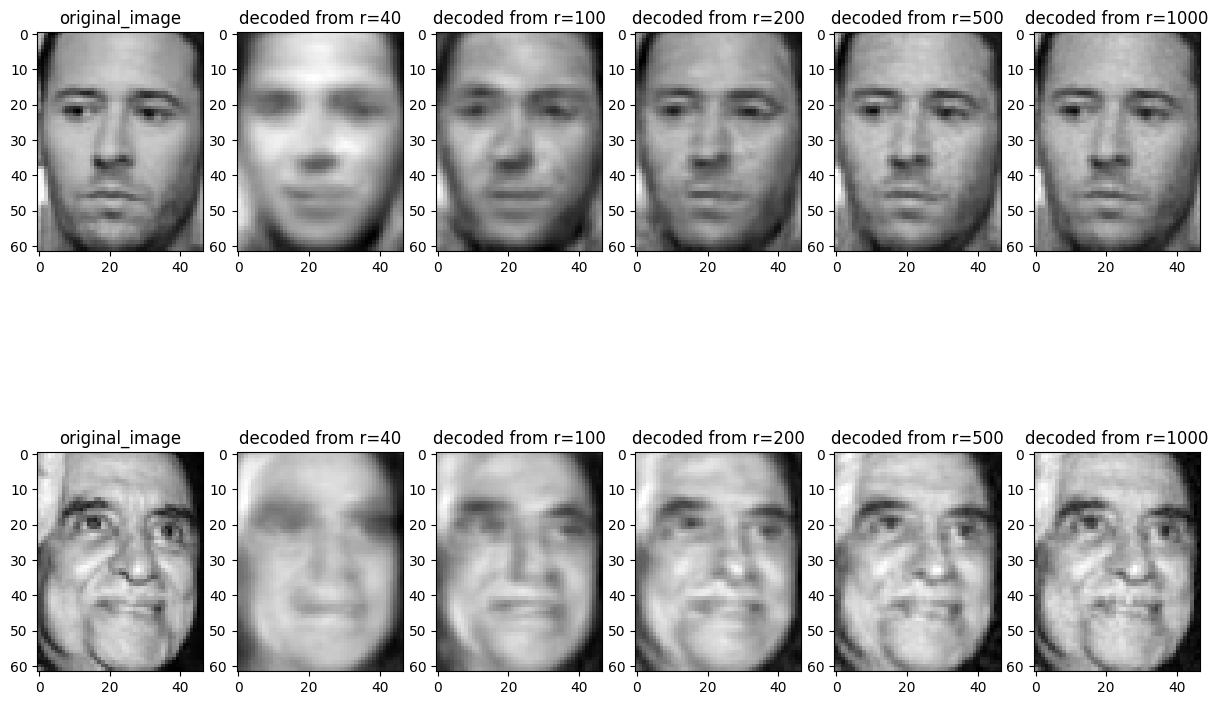

In [21]:
n_eigenfaces = [40, 100, 200, 500, 1000]
fig, ax = plt.subplots(len(compressed_faces), 1 + len(n_eigenfaces), figsize=(15, 10))

for i in range(2):
    ax[i,0].imshow(held_out_faces[i], cmap='grey')
    ax[i,0].set_title('original_image')
    
for j, n_eigenface in enumerate(n_eigenfaces):
    U_significant = U[:,:n_eigenface]

    compressed_faces = []
    for i, face in enumerate(held_out_faces):
        compressed_faces.append(U_significant.T@(face.flatten() - mean.squeeze()))
        
    reconstructed_faces = []
    for compressed_face in compressed_faces:
        reconstructed_faces.append((U_significant@compressed_face + mean.squeeze()).reshape(62, 47))

    for i in range(2):
        ax[i, 1 + j].imshow(reconstructed_faces[i], cmap='grey')
        ax[i, 1 + j].set_title(f'decoded from r={n_eigenface}')

We see that while still lossy, using several hundred components leads to very good recovery, even though we're using less than half of the data used to store the original image!

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/nikolaimatni/ese-2030/HEAD?labpath=/10_Ch_11_Principal_Component_Analysis/123-eigenfaces.ipynb)
